# Word Embeddings and Debiasing them

In [1]:
import sys
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import time

from sklearn.metrics.pairwise import pairwise_distances
from gensim.models import KeyedVectors
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.manifold import TSNE

### Glove dataset
 	

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.



In [2]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = []
        word_to_vec_map = {}
        embedding=[]
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.append(curr_word)
            vec=np.array(line[1:], dtype=np.float64)
            word_to_vec_map[curr_word] =vec
            embedding.append(vec)
            
    return words, word_to_vec_map,embedding
words, word_to_vec_map,embedding= read_glove_vecs('data/glove6b50dtxt/glove.6B.50d.txt')


In [3]:
embedding=np.array(embedding)
V,D=embedding.shape
V,D

(400000, 50)

In [4]:
n=input("Enter word to be searched: ").lower()
flag=0
for i in words:
    if i==n:
        print(i)
        print (word_to_vec_map[n])
        flag=1
        break
if flag==0:
    print('Word not found')

Enter word to be searched: computer
computer
[ 0.079084 -0.81504   1.7901    0.91653   0.10797  -0.55628  -0.84427
 -1.4951    0.13418   0.63627   0.35146   0.25813  -0.55029   0.51056
  0.37409   0.12092  -1.6166    0.83653   0.14202  -0.52348   0.73453
  0.12207  -0.49079   0.32533   0.45306  -1.585    -0.63848  -1.0053
  0.10454  -0.42984   3.181    -0.62187   0.16819  -1.0139    0.064058
  0.57844  -0.4556    0.73783   0.37203  -0.57722   0.66441   0.055129
  0.037891  1.3275    0.30991   0.50697   1.2357    0.1274   -0.11434
  0.20709 ]


Enter lower limit 3000
Enter upper limit 3250


<IPython.core.display.Javascript object>


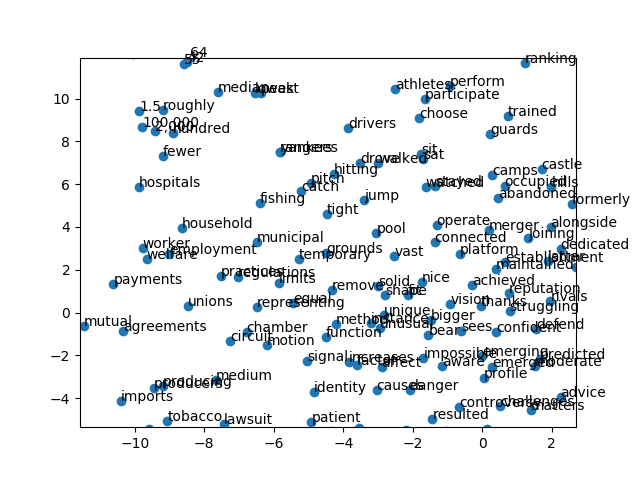

In [5]:
n1=int(input('Enter lower limit '))
n2=int(input('Enter upper limit '))
arr = np.empty((0,50), dtype='f')
word_labels=[]
l=[]
c=0
for i in word_to_vec_map:
    c=c+1
    if c>=n1 and c<=n2:    
        l.append(i)
    if c>n2:
        break
for i in l:
    word_labels.append(i)
    arr = np.append(arr, np.array([word_to_vec_map[i]]), axis=0)
tsne = TSNE(n_components=2, random_state=10)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
x_coords = Y[:, 0]
y_coords = Y[:, 1]
plt.scatter(x_coords, y_coords)

for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

# p, o to ZOOM, then ZOOM rect

## Dataset for single-label text categorization


In [6]:
test=pd.read_csv('data/r8-test-all-terms.txt',header=None,sep='\t')
train=pd.read_csv('data/r8-train-all-terms.txt',header=None,sep='\t')
train.columns = ['label', 'content']
test.columns = ['label', 'content']
test.head()

,label,content
0,trade,asian exporters fear damage from u s japan rif...
1,grain,china daily says vermin eat pct grain stocks a...
2,ship,australian foreign ship ban ends but nsw ports...
3,acq,sumitomo bank aims at quick recovery from merg...
4,earn,amatil proposes two for five bonus share issue...


In [7]:
class GloveVectorizer:
  def __init__(self):
    word2vec = {}
    embedding = []
    idx2word = []
    with open('data/glove6b50dtxt/glove.6B.50d.txt') as f:
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.lower().split()
      vecs = []
      for word in tokens:
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [8]:
vectorizer = GloveVectorizer()
Xtrain = vectorizer.fit_transform(train.content)
Ytrain = train.label
Xtest = vectorizer.transform(test.content)
Ytest = test.label


model = RandomForestClassifier(n_estimators=200)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

Found 400000 word vectors.
Numer of samples with no words found: 0 / 5485
Numer of samples with no words found: 0 / 2189
train score: 0.9992707383773929
test score: 0.9346733668341709


In [9]:
print(Xtrain)

[[ 0.26298591  0.04344983  0.10715922 ...  0.19827686 -0.00114674
  -0.03997769]
 [ 0.42225829  0.07437593  0.26020068 ...  0.17860013 -0.03726814
   0.00975073]
 [ 0.0928487   0.23682633  0.74443752 ...  0.3050805   0.21718168
  -0.00925212]
 ...
 [ 0.25140008  0.09662949  0.24585249 ...  0.39140922  0.07656725
   0.21384235]
 [ 0.02983556  0.2489665   0.17141154 ... -0.06573244  0.05871844
  -0.28075072]
 [ 0.28263831 -0.05153349  0.03966838 ...  0.20757663 -0.01583107
  -0.13377655]]


In [10]:
print(Ytrain)

0           earn
1            acq
2           earn
3           earn
4           earn
          ...   
5480        earn
5481    money-fx
5482        earn
5483    money-fx
5484        ship
Name: label, Length: 5485, dtype: object


In [11]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(5485, 50)
(5485,)
(2189, 50)
(2189,)


In [12]:
def cosine_similarity(u, v):
    distance = 0.0
    dot = np.dot(u,v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    cosine_similarity = dot / np.dot(norm_u, norm_v)
    return cosine_similarity

In [13]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]
#value closer to 1 means two words are very similar
print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))#Paris is captial of France and Rome is capital of Italy
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris,  italy- rome))#order matter county,city:country,city

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.2743924626137942
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174202
cosine_similarity(france - paris, rome - italy) =  0.6751479308174202


In [14]:
#smaller dataset
w=vectorizer.word2vec
father =w ["father"]
mother = w["mother"]
print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))

cosine_similarity(father, mother) =  0.8909039
cosine_similarity(ball, crocodile) =  0.2743924626137942


In [15]:
print("Enter two words to compare")
x1=input().lower()
x2=input().lower()
if x1 in words and x2 in words:
    w1 = word_to_vec_map[x1]
    w2 = word_to_vec_map[x2]
    print("cosine_similarity = ",cosine_similarity(w1,w2))
    print(x1," =",w1)
    print(x2," =",w2)
else:
    print("Not found")

Enter two words to compare
school
education
cosine_similarity =  0.7844985936709139
school  = [-0.90629    1.2485    -0.79692   -1.4027    -0.038458  -0.25177
 -1.2838    -0.58413   -0.11179   -0.56908   -0.34842   -0.39626
 -0.0090178 -1.0691    -0.35368   -0.052826  -0.37056    1.0931
 -0.19205    0.44648    0.45169    0.72104   -0.61103    0.6315
 -0.49044   -1.7517     0.055979  -0.52281   -1.0248    -0.89142
  3.0695     0.14483   -0.13938   -1.3907     1.2123     0.40173
  0.4171     0.27364    0.98673    0.027599  -0.8724    -0.51648
 -0.30662    0.37784    0.016734   0.23813    0.49411   -0.56643
 -0.18744    0.62809  ]
education  = [-0.9266    0.69467  -0.59079  -1.0542   -0.16538   0.26239  -0.37788
 -1.4453    0.40885  -0.30288   0.03182  -0.18016   0.42866  -0.89767
 -0.56316  -0.27027   0.045694  0.62575   1.2644    0.76223   0.55267
  0.49301  -0.60455   0.044394  0.21022  -1.4351    0.31501  -1.4332
 -1.1363    0.2626    3.642     0.71513  -0.51682  -1.3208    0.011802
 

In [16]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    words = word_to_vec_map.keys()
    max_cosine_sim = -100           
    best_word = None            
    input_words_set = set([word_a, word_b, word_c])
    for w in words:        
        if w in input_words_set:
            continue
        cosine_sim = cosine_similarity((e_b - e_a), (word_to_vec_map[w] - e_c))
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word= w
    return best_word

In [17]:
triads_to_try = [('usa', 'english', 'india'), ('india', 'delhi', 'japan'),('medicine', 'pharmacy' ,'food'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

usa -> english :: india -> sanskrit
india -> delhi :: japan -> tokyo
medicine -> pharmacy :: food -> grocery
man -> woman :: boy -> girl
small -> smaller :: large -> larger


In [18]:
def plot(l):
    arr = np.empty((0,50), dtype='f')
    word_labels=[]   
    for i in l:
        word_labels.append(i)
        arr = np.append(arr, np.array([word_to_vec_map[i]]), axis=0)
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    

neighbors of: doctor
['physician', 'nurse', 'dentist', 'colleague', 'patient', 'psychiatrist', 'teacher', 'surgeon', 'learned', 'child', 'learns', 'father', 'boy', 'victim', 'blind', 'friend', 'therapist', 'doctors', 'finds', 'companion', 'pharmacist', 'man', 'taken', 'tells', 'dying', 'pediatrician', 'parents', 'woman', 'mother', 'dr.', 'she', 'person', 'brother', 'discovers', 'informs', 'dies', 'counselor', 'another', 'admitted', 'knew', 'takes', 'heart', 'reveals', 'life', 'roommate', 'explained', 'lover', 'medical', 'worked', 'goes']


<IPython.core.display.Javascript object>


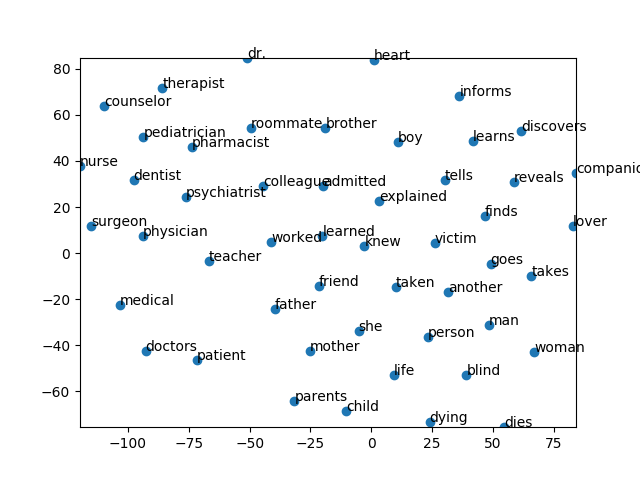

In [19]:
def nearest_neighbors(w, n=50):
    if w not in word_to_vec_map:
        print("%s not in dictionary:" % w)
        return

    v = word_to_vec_map[w]
    distances = pairwise_distances(v.reshape(1, D), embedding).reshape(V)
    idxs = distances.argsort()[1:n+1]
    print("neighbors of: %s" % w)
    l=[]
    for idx in idxs:
        l.append(words[idx])
    return l
l=nearest_neighbors('doctor')
#l=nearest_neighbors('france')
#l=nearest_neighbors('india')
#l=nearest_neighbors('einstein')
l#=nearest_neighbors('woman')
#l=nearest_neighbors('data')
#l=nearest_neighbors('february')
#l=nearest_neighbors('rome')
print(l)
plot(l)

In [20]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


In [21]:
print('Other words and their similarities:')
word_list = ['science', 'arts', 'literature', 'warrior','doctor', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
science -0.06082906540929701
arts 0.008189312385880337
literature 0.06472504433459932
warrior -0.20920164641125288
doctor 0.11895289410935041
receptionist 0.3307794175059374
technology -0.13193732447554302
fashion 0.03563894625772699
teacher 0.17920923431825664
engineer -0.0803928049452407
pilot 0.0010764498991916937
computer -0.10330358873850498
singer 0.1850051813649629



###  Neutralize bias for non-gender specific words 

The 50 dimensional space can be split into two parts: The bias-direction $g$, and the remaining 49 dimensions, which we'll call $g_{\perp}$. The 49 dimensional $g_{\perp}$ is perpendicular to $g$. The neutralization step takes a vector such as $e_{receptionist}$ and zeros out the component in the direction of $g$, giving us $e_{receptionist}^{debiased}$. 

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{1}$$
$$e^{debiased} = e - e^{bias\_component}\tag{2}$$

 $e^{bias\_component}$ is the projection of $e$ onto the direction $g$

<!-- 
**Reminder**: a vector $u$ can be split into two parts: its projection over a vector-axis $v_B$ and its projection over the axis orthogonal to $v$:
$$u = u_B + u_{\perp}$$
where : $u_B = $ and $ u_{\perp} = u - u_B $
!--> 


In [22]:
def neutralize(word, g, word_to_vec_map):
    '''
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    '''
    e= word_to_vec_map[word]
    e_biascomponent = (np.dot(e, g)/np.square(np.linalg.norm(g)))*g
    e_debiased = e - e_biascomponent
    return e_debiased

In [23]:
e = "receptionist"
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))



cosine similarity between receptionist and g, before neutralizing:  0.3307794175059374
cosine similarity between receptionist and g, after neutralizing:  -2.099120994400013e-17


###  Equalization algorithm for gender-specific words



In [24]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    w1, w2 = pair[0], pair[1]
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]
    mu = (e_w1+e_w2)/2
    #Compute the projections of mu over the bias axis and the orthogonal axis 
    mu_B = (np.dot(mu, bias_axis)/np.square(np.linalg.norm(bias_axis)))*bias_axis
    mu_orth = mu - mu_B
    e_w1B = (np.dot(e_w1, bias_axis)/np.square(np.linalg.norm(bias_axis)))*bias_axis
    e_w2B = (np.dot(e_w2, bias_axis)/np.square(np.linalg.norm(bias_axis)))*bias_axis
    corrected_e_w1B = np.sqrt(np.absolute(1-np.square(np.linalg.norm(mu_orth))))*(e_w1B-mu_B)/np.absolute(e_w1-mu_orth-mu_B)
    corrected_e_w2B = np.sqrt(np.absolute(1-np.square(np.linalg.norm(mu_orth))))*(e_w2B-mu_B)/np.absolute(e_w2-mu_orth-mu_B)
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    return e1, e2

In [25]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.11711095765336832
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.7165727525843935
cosine_similarity(e2, gender) =  0.7396596474928909


**References**:
- The debiasing algorithm is from Bolukbasi et al., 2016, [Man is to Computer Programmer as Woman is to
Homemaker? Debiasing Word Embeddings](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf)
- The GloVe word embeddings (https://nlp.stanford.edu/projects/glove/)
- Single-label text categorization dataset [https://www.cs.umb.edu/~smimarog/textmining/datasets/]
